## Задание 1
Сравнить МНК-оценку для линейной регрессии с методом наименьших модулей в случае, когда шум порожден из распределения Лапласа. Когда оценки совпадают, а когда сильно различаются?

In [77]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm

Напишем функци генерации точек с шумом из распределения Лапласа, а так же функцию, вычисляющую параметры регрессии по методу наименьших модулей

In [40]:
def fit(X, params):
    return X.dot(params)


def cost_function(params, X, y):
    return np.sum(np.abs(y - fit(X, params)))

In [216]:
def generate_data(size, low, high, laplace_scale):
    data = pd.DataFrame(columns = ["y", "x", "c"])
    data["x"] = np.random.uniform(low, high, size)
    data["c"] = np.ones(size)
    params = np.array([3.5, 10])
    data["y"] = data["x"]*params[0] + params[1] + np.random.laplace(scale = laplace_scale, size = size)
    #plt.plot(data["x"],  data["y"], "o")
    return data, params

In [217]:
output = minimize(cost_function, np.array([-50., -50.]).reshape(-1, 1), args=(data.iloc[:, 1:3].values, data["y"]))

y_hat = fit(data.iloc[:, 1:3].values, output.x)

### Гипотеза:  МНК и МНМ(метод наименьших модулей) оценки могут различаться, когда либо "информации" для построения регрессии мало, либо когда шум из рампределения Лапласа очень не похож на гаусовский
Соответственно, будем проверять зависимость оценок регрессии от:
 - Размера выборки
 - Количества признаков
 - Дисперсии в распределении Лапласа

### Зависимость разницы оценок от размера выборки:

In [218]:
params_mls = []
params_mlm = []
resid_mls = []
resid_mlm = []
diff = []
n_list = np.arange(3, 1000, 50)
data, params = generate_data(1000, -300, 300, 150)
for n in n_list:
    data1 = data.sample(n)
    output = minimize(cost_function, np.array([0., 0.]).reshape(-1, 1), args=(data1.iloc[:, 1:3].values, data1["y"]))
    params_mlm.append(output.x)
    resid_mlm.append(np.abs(data1["y"].values - fit(data1.iloc[:, 1:3].values, output.x)))
    model = sm.OLS.from_formula('y~x', data1)
    res = model.fit()
    params_mls.append([res.params["x"], res.params["Intercept"]])
    resid_mls.append(res.resid.abs().values)
    diff.append(np.abs(fit(data1.iloc[:, 1:3].values, output.x) - res.predict()))
    

Построим график зависимости среднего от модулей разницы mean_diff =  $\frac{1}{n}\sum_{i = 1}^{n}|\hat{y}_{i}^{mls} - \hat{y}_{i}^{mlm}|$ от размера выборки $n$

Text(0, 0.5, 'mean_diff')

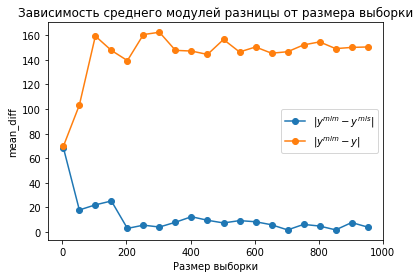

In [219]:
diff_mean = [np.mean(el) for el in diff]
resid_mean = [np.mean(el) for el in resid_mlm]
p1 = plt.plot(n_list, diff_mean, "o-")
p2 = plt.plot(n_list, resid_mean, "o-")
plt.legend((p1[0], p2[0]), ("$|y^{mlm} - y^{mls}|$", '$|y^{mlm} - y|$',))
plt.title("Зависимость среднего модулей разницы от размера выборки" )
plt.xlabel("Размер выборки")
plt.ylabel("mean_diff")

##### Вывод: гипотеза подтверждается, видим, что про малом размере выборки оценки сильно отличаются, но гораздо меньше, чем отличие оценок $y^{mlm}$ от реальных $y$(которое варьируется вокруг  параметра масштаба в распределении Лапласа) 


## Зависимость от scale в параметрах распределения Лапаса

Генерируем выборки с разны значением $\lambda$

In [223]:
params_mls = []
params_mlm = []
resid_mls = []
resid_mlm = []
diff = []
size = 100
data = pd.DataFrame(columns = ["y", "x", "c"])
data["x"] = np.random.uniform(-150, 150, size)
data["c"] = np.ones(size)
params = np.random.uniform(-20., 20., 2).reshape(-1, 1)
y_clear = data["x"].values*params[0] + params[1]
scales = np.arange(1, 1000, 50)
for scale in scales:
    data["y"] = y_clear + np.random.laplace(scale = scale, size = size)
    output = minimize(cost_function, np.array([0., 0.]).reshape(-1, 1), args=(data.iloc[:, 1:3].values, data["y"]))
    params_mlm.append(output.x)
    resid_mlm.append(np.abs(data["y"].values - fit(data.iloc[:, 1:3].values, output.x)))
    model = sm.OLS.from_formula('y~x', data)
    res = model.fit()
    params_mls.append([res.params["x"], res.params["Intercept"]])
    resid_mls.append(res.resid.abs().values)
    diff.append(np.abs(fit(data.iloc[:, 1:3].values, output.x) - res.predict()))

Text(0, 0.5, 'mean_diff')

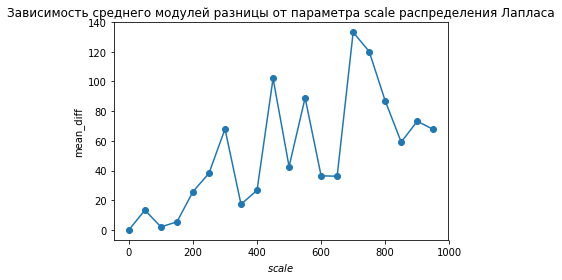

In [227]:
diff_mean = [np.mean(el) for el in diff]
plt.plot(scales, diff_mean, "o-")
#resid_mean = [np.mean(el) for el in resid_mlm]
#plt.plot(n_list, resid_mean, "o-")
plt.title("Зависимость среднего модулей разницы от параметра scale распределения Лапласа" )
plt.xlabel("$scale$")
plt.ylabel("mean_diff")

#### Вывод: гипотеза подтверждается, в целом увеличение $scale$ влечет за собой увеличение разницы оценок(но, опять же, не такой значительный, как разница между $y^{mlm}$ и реальными $y$, которая $\sim scale$)

## Зависимость от размерности признаков

In [249]:
params_mls = []
params_mlm = []
resid_mls = []
resid_mlm = []
diff = []
scale = 50
size = 150
noise = np.random.laplace(scale = scale, size = size)
data = pd.DataFrame(columns = ["y", "x", "c"])
data["x"] = np.random.uniform(-150, 150, size)
data["c"] = np.ones(size)
formula = "y~x"
params = np.random.uniform(-20., 20., 12).reshape(-1, 1)
for i in range(10):
    data["y"] = fit(data.iloc[:, 1:i + 3].values, params[:i + 2]) + noise
    output = minimize(cost_function, np.zeros(i + 2), args=(data.iloc[:, 1:i + 3].values, data["y"]))
    params_mlm.append(output.x)
    resid_mlm.append(np.abs(data["y"].values - fit(data.iloc[:, 1:i + 3].values, output.x)))
    model = sm.OLS.from_formula(formula, data)
    res = model.fit()
    params_mls.append([res.params])
    resid_mls.append(res.resid.abs().values)
    diff.append(np.abs(fit(data.iloc[:, 1:i + 3].values, output.x) - res.predict()))
    formula += "+ x_" + str(i)
    data["x_" + str(i)] = np.random.uniform(-150, 150, size)

Text(0, 0.5, 'mean_diff')

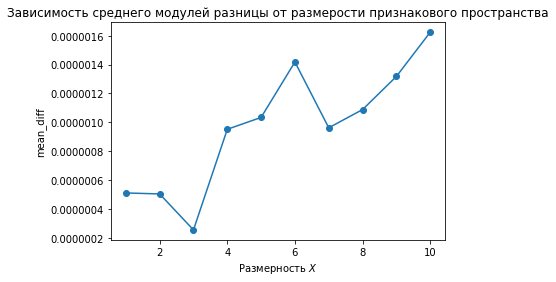

In [251]:
diff_mean = [np.mean(el) for el in diff]
plt.plot(np.arange(1, 11), diff_mean, "o-")
plt.title("Зависимость среднего модулей разницы от размерости признакового пространства")
plt.xlabel("Размерность $X$")
plt.ylabel("mean_diff")

#### Выводы: здесь разницы между моделями практически нет

### Выводы:
 - Наблюдается увеличение разницы между моделями на маленьких выборках
 - Наблюдается увеличение разницы при увеличении scale в параметрах Лапласа
Это происходит скорее всего потому, что когда доля шума в данных значительна, алгоритмы минимизации работают по-разному и получают разные модели